In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import json
import random
import numpy as np
import os

c:\Users\nghoo\AppData\Local\anaconda3\envs\hallucination_llm_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [3]:
SAVE_DIR = "./model"
TEST_PATH = "../test.jsonl"
MAX_LEN = 256
BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR, use_fast=False, trust_remote_code=True)
model = AutoModelForSequenceClassification.from_pretrained(SAVE_DIR, trust_remote_code=True)
model.to(device)
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [5]:
label2id = {"no": 0, "extrinsic": 1, "intrinsic": 2}
id2label = {v: k for k, v in label2id.items()}

In [6]:
class JsonlDataset(Dataset):
    def __init__(self, path, tokenizer, max_len=256):
        self.samples = []
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                self.samples.append(json.loads(line))
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        text = " ".join([m["content"] for m in sample["messages"]])
        label = label2id[sample["label"]]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label)
        }

In [7]:
test_dataset = JsonlDataset(TEST_PATH, tokenizer, max_len=MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels_batch = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

In [9]:
print("===== Classification Report =====")
print(classification_report(all_labels, all_preds, target_names=list(label2id.keys()), digits=4))

===== Classification Report =====
              precision    recall  f1-score   support

          no     0.0000    0.0000    0.0000         7
   extrinsic     0.4615    0.8571    0.6000         7
   intrinsic     0.4286    0.5000    0.4615         6

    accuracy                         0.4500        20
   macro avg     0.2967    0.4524    0.3538        20
weighted avg     0.2901    0.4500    0.3485        20



c:\Users\nghoo\AppData\Local\anaconda3\envs\hallucination_llm_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nghoo\AppData\Local\anaconda3\envs\hallucination_llm_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nghoo\AppData\Local\anaconda3\envs\hallucination_llm_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

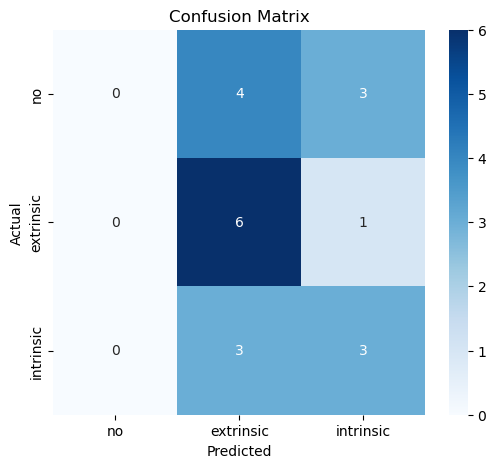

In [10]:
cm = confusion_matrix(all_labels, all_preds, labels=[0,1,2])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(label2id.keys()),
            yticklabels=list(label2id.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [11]:
def predict(text):
    model.eval()
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**encoding)
        pred = torch.argmax(outputs.logits, dim=1).item()
    return id2label[pred]

In [12]:
print("\n===== Misclassified Samples =====")
for i, (pred, true) in enumerate(zip(all_preds, all_labels)):
    if pred != true:
        sample = test_dataset[i]
        text_sample = tokenizer.decode(sample["input_ids"], skip_special_tokens=True)
        print(f"Sample {i}:\nText: {text_sample}\nTrue: {id2label[true]}, Pred: {id2label[pred]}\n")


===== Misclassified Samples =====
Sample 1:
Text: Những cư dân đầu tiên sinh sống tại Puerto Rico là người da đỏ châu Mỹ, sau đó được tiếp nối bởi người da trắng gốc châu Âu và người da đen gốc châu Phi. Thế kỉ 19 đánh dấu một giai đoạn bùng nổ dân nhập cư vào Puerto Rico khi hàng trăm gia đình đổ vào đất nước này để được cấp đất theo Sắc lệnh năm 1815, theo đó cung cấp một lượng đất đai cho những người dân gốc châu Âu theo Công giáo Rôma. Chủ yếu người da trắng tại Puerto Rico có tổ tiên là người Tây Ban Nha, bên cạnh đó cũng có một số dân tộc khác như Bồ Đào Nha, Ý, Scotland, Ireland, Đức... Người da đen đến Puerto Rico trên những con tàu buôn nô lệ đã góp phần làm nên sự đa dạng chủng tộc tại hòn đảo này. Bên cạnh đó, Puerto Rico còn có một cộng đồng người gốc châu Á với các sắc dân Trung Quốc, Liban. Người dân các nước Mỹ Latinh cũng góp thêm vào các dòng người nhập cư từ Colombia, Venezuela, Argentina, Cuba và Cộng hòa Dominicana. Tình trạng nhập cư vào thế kỉ 19 này đã khiến dân